**Student Name - Aditya Bhavsar**

## Define Model

$$
\begin{matrix}
\text{Input 1: text}, X_1 & \rightarrow & \text{embed}: E(X_1) & \rightarrow & N_1(E(X_1)) \\
  & & & & \searrow \\
  & & & &          & \oplus \rightarrow N_3 \bigg( \underbrace{N_1(E(X_1))}_\text{text}, \underbrace{N_2(X_2)}_\text{func rating} \bigg) \\
  & & & & \nearrow \\
& & \text{Input 2: function rating}, X_2 & \rightarrow & N_2(X_2) \\
\end{matrix}
$$

#Import required libraries

In [ ]:
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


# Load tokenizer and model

In [ ]:
# Setting Hugging face token
import os
os.environ["HF_TOKEN"] = "Your HF token"

from huggingface_hub import login
login(token=os.environ["HF_TOKEN"])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [ ]:
def round_predictions(predictions):
    """Round predictions to the nearest integer based on custom rules."""
    return np.where((predictions % 1) > 0.5, np.ceil(predictions), np.floor(predictions))

def stars_from_rating(rating):
    """Convert numeric rating to stars."""
    return "★" * int(rating)

In [ ]:
# Load the tokenizer and model
model_name = "sentence-transformers/all-MiniLM-L12-v2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


# Model

In [ ]:
# Unfreeze more BERT layers for fine-tuning
for layer in bert_model.layers[:2]:
    layer.trainable = False

def encode_text(texts, tokenizer, max_length=128):
    """Tokenize and encode input texts."""
    encoded = tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="np")
    return encoded["input_ids"], encoded["attention_mask"]

def create_bert_nn_model():
    """Creates a neural network using MiniLM embeddings."""
    text_input = Input(shape=(128,), dtype=tf.int32, name="text_input")
    attention_mask = Input(shape=(128,), dtype=tf.int32, name="attention_mask")

    def bert_layer(inputs):
        return bert_model(inputs[0], attention_mask=inputs[1])[0][:, 0, :]

    bert_output = Lambda(bert_layer, output_shape=(384,))([text_input, attention_mask])

    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(bert_output)
    x = Dropout(0.4)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.4)(x)

    func_rating_input = Input(shape=(1,), dtype=tf.float32, name="func_rating_input")
    y = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(func_rating_input)

    concatenated = Concatenate()([x, y])
    output = Dense(1, activation='linear', name="output")(concatenated)

    optimizer = AdamW(learning_rate=1e-5)
    model = Model(inputs=[text_input, attention_mask, func_rating_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Loading Dataset

In [ ]:
df = pd.read_csv("/content/Combined.csv")

In [ ]:
df.head()

,user_prompt,url_to_check,func_rating,custom_rating
0,"I have just been on an international flight, c...",https://www.mayoclinic.org/healthy-lifestyle/i...,2,3
1,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,4
2,What are the benefits of a vegetarian diet?,https://www.nhs.uk/live-well/eat-well/how-to-e...,2,2
3,What are the benefits of a vegetarian diet?,https://pubmed.ncbi.nlm.nih.gov/37226630/#:~:t...,2,3
4,How to improve mental health during stressful ...,https://www.who.int/news-room/questions-and-an...,3,3


# Encoding the given data and verfying the dimensionality/Shape

In [ ]:
# Encode user prompts
X_text, X_mask = encode_text(df['user_prompt'], tokenizer, max_length=128)
X_text = np.array(X_text)
X_mask = np.array(X_mask)
X_numeric = df['func_rating'].values.reshape(-1, 1).astype(np.float32)
Y = df['custom_rating'].values.reshape(-1, 1).astype(np.float32)

#Creating and training the model

In [ ]:
# Create and train the model
model = create_bert_nn_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    [X_text, X_mask, X_numeric], Y,
    epochs=100, batch_size=16, validation_split=0.1,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 16.4744 - mae: 2.7488 - val_loss: 15.4221 - val_mae: 2.6346 - learning_rate: 1.0000e-05
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - loss: 16.2522 - mae: 2.7369 - val_loss: 14.9257 - val_mae: 2.5396 - learning_rate: 1.0000e-05
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 14.9181 - mae: 2.4695 - val_loss: 14.4658 - val_mae: 2.4480 - learning_rate: 1.0000e-05
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 14.8576 - mae: 2.4746 - val_loss: 14.0172 - val_mae: 2.3554 - learning_rate: 1.0000e-05
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - loss: 14.2389 - mae: 2.3417 - val_loss: 13.5926 - val_mae: 2.2642 - learning_rate: 1.0000e-05
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 13.8258 - mae: 2.2799 - val_loss: 13.1844 - val_mae: 2.1729 - learning_rate: 1.0000e-05
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - loss: 13.7176 - mae: 2.2045 - val_loss: 12.7955 - val_mae: 2.0822

#Making predictions and saving it as a .csv file

In [ ]:
# Make predictions
predictions = model.predict([X_text, X_mask, X_numeric])
rounded_predictions = round_predictions(predictions)
star_ratings = [stars_from_rating(r) for r in rounded_predictions.flatten()]

# Save results
df['Predicted_Rating'] = rounded_predictions.astype(int)
df['Stars'] = star_ratings
df.to_csv("/content/Predicted_Results.csv", index=False)

9/9 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step


# Plotting training and validation loss

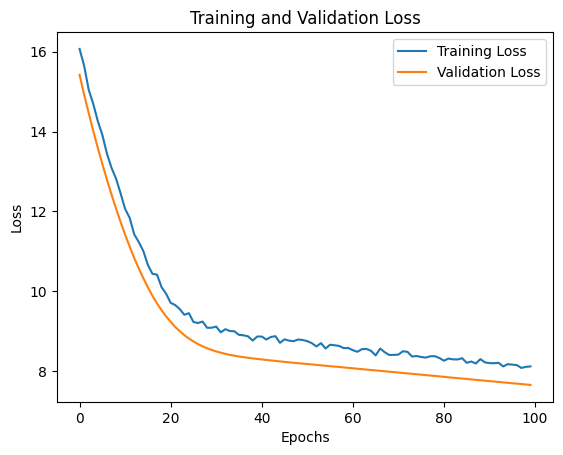

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ text_input (InputLayer)   │ (None, 128)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_mask            │ (None, 128)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 384)            │              0 │ text_input[0][0],      │
│                           │                        │                │ attention_mask[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        197,120 │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ func_rating_input         │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 64)             │            128 │ func_rating_input[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 320)            │              0 │ dropout_1[0][0],       │
│                           │                        │                │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ output (Dense)            │ (None, 1)              │            321 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 986,693 (3.76 MB)

 Trainable params: 328,897 (1.25 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 657,796 (2.51 MB)

# Testing our model

In [ ]:
test_texts = ["This is a great product!", "Not very useful.", "Could be better", "Absolutely loved it!"]
test_func_ratings = np.array([[4], [2], [3], [5]], dtype=np.float32)

test_text_ids, test_text_masks = encode_text(pd.Series(test_texts), tokenizer, max_length=128)

test_predictions = model.predict([test_text_ids, test_text_masks, test_func_ratings])
rounded_test_predictions = round_predictions(test_predictions)
test_star_ratings = [stars_from_rating(r) for r in rounded_test_predictions.flatten()]

for text, rating, stars in zip(test_texts, rounded_test_predictions.flatten(), test_star_ratings):
    print(f"Text: {text}\nPredicted Rating: {int(rating)}\nStars: {stars}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Text: This is a great product!
Predicted Rating: 3
Stars: ★★★

Text: Not very useful.
Predicted Rating: 2
Stars: ★★

Text: Could be better
Predicted Rating: 2
Stars: ★★

Text: Absolutely loved it!
Predicted Rating: 3
Stars: ★★★



## Create Repo on HF

In [ ]:
! pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.28.1
    Uninstalling huggingface-hub-0.28.1:
      Successfully uninstalled huggingface-hub-0.28.1


In [ ]:
import os
from huggingface_hub import HfApi, login

os.environ["HUGGINGFACE_TOKEN"] = "Your HF token"  # Replace with your token

hf_username = "username"# Set your hf username here
repo_name = "my-tensorflow-model"# keep your personalized name for the model
repo_id = f"{hf_username}/{repo_name}"

token = os.environ.get("HUGGINGFACE_TOKEN")

login(token=token)

api = HfApi()

api.create_repo(repo_id=repo_id, exist_ok=True)

print(f"Repository created: https://huggingface.co/{repo_id}")

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Repository created: https://huggingface.co/Aditya-1911/my-tensorflow-model


## Push Artifacts on HF

In [ ]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"username/{repo_name}"  # Change as needed- Add your username
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

model.keras:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

tokenizer.pkl:   0%|          | 0.00/468k [00:00<?, ?B/s]

Model and tokenizer successfully pushed to: https://huggingface.co/Aditya-1911/my-tensorflow-model


## Download Model Artifact from HF

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Ensure correct backend (optional)
#os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
repo_id = "username/my-tensorflow-model"#-Add your username here
filename = "model.keras"

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Define the registered function before loading
def bert_layer(inputs):
    return bert_model(inputs[0], attention_mask=inputs[1])[0][:, 0, :]

# Load the Keras model with custom objects
new_model = keras.models.load_model(model_path, custom_objects={"bert_layer": bert_layer})

print("Model loaded successfully!")


model.keras:   0%|          | 0.00/3.99M [00:00<?, ?B/s]

Model loaded successfully!
